In [1]:
from matplotlib.pylab import rcParams
import xlrd
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
rcParams["figure.figsize"] = 10,10

df = pd.read_excel(
     os.path.join("Case_License_Volume_2021-06-01_08-43-48.xlsx"),sheet_name="Data", engine='openpyxl',
)

# set dtypes
df["Period"] = pd.to_datetime(df.Period)

#dropna
df.dropna(how="any")
#we group the AG and Period as a sum to get the distinctive variables and avoid duplicates.
#here we create grouped Date Frame with out any index, in order to manipulate with AG and period later on.
df = df.groupby(["Application Group", "Period"], as_index = False).sum()

#to assign application groups to certain index we group them by App Gr.
df["Index"] = df.groupby(["Application Group"]).ngroup()

In [4]:
#see the best fit application which corresponds max data points
lst = []
for i in range(0, 25):
    filt = df["Index"] == i
    model = df.loc[filt,["Period", "Case Count"]]
    m = [len(model)]
    lst = lst + m
print("Maximum of Datapoints:", max(lst),"\nApplication Name:", df.loc[filt,["Application Group"]].iloc[0,0], 
      "\nApplication Number:", i)

Maximum of Datapoints: 19 
Application Name: UOM 
Application Number: 24


In [ ]:
new_df = df["Index"] == 24
df = df.loc[filt,["Period", "Case Count"]]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\pandas\core\indexes\base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Index'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-3577152928de>", line 1, in <module>
    new_df = df["Index"] == 24
  File "C:\Users\

In [ ]:
df = df.set_index('Period').resample('MS').ffill() # fill the years if necessary
df

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-0c6f8312c8b7>", line 1, in <module>
    df = df.set_index('Period').resample('MS').ffill() # fill the years if necessary
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\pandas\core\frame.py", line 4555, in set_index
    raise KeyError(f"None of {missing} are in the columns")
KeyError: "None of ['Period'] are in the columns"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (mo

In [30]:
dataset = df["Case Count"].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


#define the function to prepare data.
#reorganize the data to form feature vectors and target values.

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), ]
        X.append(a)
        Y.append(dataset[i + look_back, ])
    return np.array(X), np.array(Y)
    
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [31]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=2000, batch_size=5, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 14 samples, validate on 2 samples
Epoch 1/2000
14/14 [==============================] - 1s 40ms/step - loss: 0.0319 - val_loss: 0.6584
Epoch 2/2000
14/14 [==============================] - 0s 570us/step - loss: 0.0291 - val_loss: 0.6303
Epoch 3/2000
14/14 [==============================] - 0s 499us/step - loss: 0.0276 - val_loss: 0.6033
Epoch 4/2000
14/14 [==============================] - 0s 570us/step - loss: 0.0256 - val_loss: 0.5777
Epoch 5/2000
14/14 [==============================] - 0s 570us/step - loss: 0.0233 - val_loss: 0.5532
Epoch 6/2000
14/14 [==============================] - 0s 640us/step - loss: 0.0219 - val_loss: 0.5297
Epoch 7/2000
14/14 [==============================] - 0s 712us/step - loss: 0.0203 - val_loss: 0.5074
Epoch 8/2000
14/14 [==============================] - 0s 499us/step - loss: 0.0204 - val_loss: 0.4865
Epoch 9/2000
14/14 [==============================] - 0s 784us/step - loss: 0.0189 - val_loss: 0.4669
Epoch 10/2000
14/14 [===================

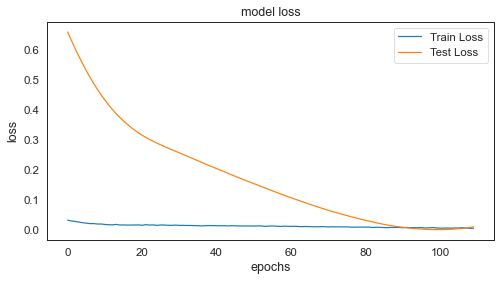

In [32]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [33]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# # invert predictions
train_predict = scaler.inverse_transform(train_predict)

Y_train = scaler.inverse_transform(Y_train.reshape(-1,1)).reshape(Y_train.shape)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)



ERROR! Session/line number was not unique in database. History logging moved to new session 401


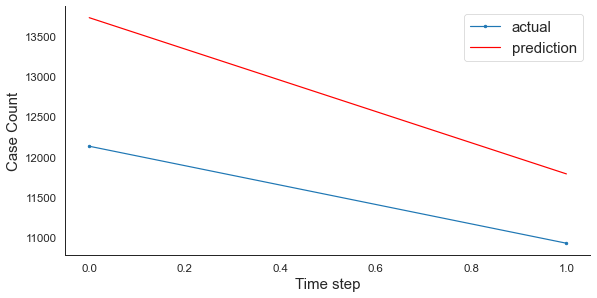

In [35]:
aa=[x for x in range(2)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:,0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Case Count', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();